# First Week Streams Predictor

#### This application will source a variety of data points to predict the amount of streams a given song will recieve during its first week of publicaiton. We will use song attributes, artist information, lyrics, and public  sentiments from Spotify, Genius, and Twitter as model features.

### Imports

I conduct all of my imports at the top of my notebook to make them easy to find for reference. Each of these tool sets help us to access, analyze, transform or visualize the data used to train our predictions.

In [2]:
from simple_spotify.api import Spotify
from simple_spotify.authorization import ClientCredentialsFlow
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from googlesearch import search, search_news

import nltk
# nltk.download('all') #if neededb
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import time
import requests
import urllib3
import matplotlib.pylab as plt




## Building Training DataSet

The training data set will be used to train our model on the features important to our target result of first weeks total streams. Currently we are using data from several sources including

-  Spotify - for song information, audio analysis of songs, artist information, first week streams numbers
-  Google for public digital information about the artist or song
-  Twitter  to get an understanding for the current public sentiments for artist and songs
-  Genius to obtain the lyrics for each song to feed Natural Language Processing

### Connect with Spotify AP.

Here we establish connection with the spotify web api. We use the Spotify method using Client Credential workflow for authorization and subsequent request. To simplify the we use well balanced Spotify -Python package named simple_spotify which helps format request and response to work well with Spotify API. 

We store our client credentials obtained from our spotify developer account. We then request and store a currrent client access token which is then passed with further request.

In [2]:
res = ClientCredentialsFlow.token_request(
    'bf89fa2646f24dda9c1ca11bf97a3421',
    'b91f672d0b004ba2a5a7557ea2b1905f'
)

auth = ClientCredentialsFlow(**res)
sp = Spotify(auth)

result = sp.search(q='gucci gospel')

result.tracks.items[0].name
# for album in result.albums.items:
#     print(album.name)

'GOSPEL (feat. Chance The Rapper, Gucci Mane & YK Osiris)'

In [3]:
result.tracks.items[0].album.name

'KIRK'

In [26]:
# DEPRICATED FOR V1, AVAILABLE IN V2
# #Get Audio Analysis for Track using Track ID
# results2 = sp.get_audio_analysis(path_param = '0WoAkdHmgPmEXfiBox1flk')

In [139]:
# DEPRICATED FOR V1, AVAILABLE IN V2
# # Get the Audio Features for Single Track
# results3 = sp.get_audio_feature(path_param = '0WoAkdHmgPmEXfiBox1flk')
# results3.danceability

### Download The Chart Position Data

As of the publication of this application, Spotify does not provide first week stream counts for songs. Since this is the very metric we are trying to predict, we need to go about gathering this data via another method. 

I have found that we can derive first weeks stream counts for songs which appear in the Top 200 global charts. To Derive this data we will download the weekly charts for the past 35 weeks. Then we compare charts week by week to see which songs appear on the chart this week which were not present the previous week, and we consider this the songs first week on the chart, and we use the total streams at the end of week one as the first week streams.  

I understand this approach has a shortcomings as there may be cases when a song could be released for a number of weeks prior to making the top 200 charts list. In such case, we would not account for the stream counts for the weeks prior to making the chart. We can not account for these edge cases as Spotify does not make this data easily accessible.

In the step below I have downloaded the last 35 weeks of charts to the data folder, so now we simply read in the data to individual files. We skip the first row which is not needed.

In [14]:

df_last_week = pd.read_csv('data/regional-global-weekly-latest.csv',skiprows=1)
df_two_weeks = pd.read_csv('data/regional-global-weekly-2019-11-08--2019-11-15.csv',skiprows=1)
df_three_weeks = pd.read_csv('data/regional-global-weekly-2019-11-01--2019-11-08.csv',skiprows=1)
df_four_weeks = pd.read_csv('data/regional-global-weekly-2019-10-25--2019-11-01.csv',skiprows=1)
df_five_weeks = pd.read_csv('data/regional-global-weekly-2019-10-18--2019-10-25.csv',skiprows=1)
df_six_weeks = pd.read_csv('data/regional-global-weekly-2019-10-18--2019-10-25.csv',skiprows=1)
df_seven_weeks = pd.read_csv('data/regional-global-weekly-2019-10-11--2019-10-18.csv',skiprows=1)
df_eight_weeks = pd.read_csv('data/regional-global-weekly-2019-10-04--2019-10-11.csv',skiprows=1)
df_nine_weeks = pd.read_csv('data/regional-global-weekly-2019-09-27--2019-10-04.csv',skiprows=1)
df_ten_weeks = pd.read_csv('data/regional-global-weekly-2019-09-20--2019-09-27.csv',skiprows=1)
df_eleven_weeks = pd.read_csv('data/regional-global-weekly-2019-09-13--2019-09-20.csv',skiprows=1)
df_twelve_weeks = pd.read_csv('data/regional-global-weekly-2019-09-06--2019-09-13.csv',skiprows=1)
df_thirteen_weeks = pd.read_csv('data/regional-global-weekly-2019-08-30--2019-09-06.csv',skiprows=1)
df_fourteen_weeks = pd.read_csv('data/regional-global-weekly-2019-08-23--2019-08-30.csv',skiprows=1)
df_fifteen_weeks = pd.read_csv('data/regional-global-weekly-2019-08-16--2019-08-23.csv',skiprows=1)
df_sixteen_weeks = pd.read_csv('data/regional-global-weekly-2019-08-09--2019-08-16.csv',skiprows=1)
df_seventeen_weeks = pd.read_csv('data/regional-global-weekly-2019-08-02--2019-08-09.csv',skiprows=1)
df_eighteen_weeks = pd.read_csv('data/regional-global-weekly-2019-07-26--2019-08-02.csv',skiprows=1)
df_nineteen_weeks = pd.read_csv('data/regional-global-weekly-2019-07-19--2019-07-26.csv',skiprows=1)
df_twenty_weeks = pd.read_csv('data/regional-global-weekly-2019-07-12--2019-07-19.csv',skiprows=1)
df_twentyone_weeks = pd.read_csv('data/regional-global-weekly-2019-07-05--2019-07-12.csv',skiprows=1)
df_twentytwo_weeks = pd.read_csv('data/regional-global-weekly-2019-06-28--2019-07-05.csv',skiprows=1)
df_twentythree_weeks = pd.read_csv('data/regional-global-weekly-2019-06-21--2019-06-28.csv',skiprows=1)
df_twentyfour_weeks = pd.read_csv('data/regional-global-weekly-2019-06-14--2019-06-21.csv',skiprows=1)
df_twentyfive_weeks = pd.read_csv('data/regional-global-weekly-2019-06-14--2019-06-21.csv',skiprows=1)
df_twentysix_weeks = pd.read_csv('data/regional-global-weekly-2019-06-07--2019-06-14.csv',skiprows=1)
df_twentyseven_weeks = pd.read_csv('data/regional-global-weekly-2019-05-31--2019-06-07.csv',skiprows=1)
df_twentyeight_weeks = pd.read_csv('data/regional-global-weekly-2019-05-24--2019-05-31.csv',skiprows=1)
df_twentynine_weeks = pd.read_csv('data/regional-global-weekly-2019-05-17--2019-05-24.csv',skiprows=1)
df_thirty_weeks = pd.read_csv('data/regional-global-weekly-2019-05-10--2019-05-17.csv',skiprows=1)
df_thirtyone_weeks = pd.read_csv('data/regional-global-weekly-2019-04-26--2019-05-03.csv',skiprows=1)
df_thirtytwo_weeks = pd.read_csv('data/regional-global-weekly-2019-04-19--2019-04-26.csv',skiprows=1)
df_thirtythree_weeks = pd.read_csv('data/regional-global-weekly-2019-04-12--2019-04-19.csv',skiprows=1)
df_thirtyfour_weeks = pd.read_csv('data/regional-global-weekly-2019-04-05--2019-04-12.csv',skiprows=1)
df_thirtyfive_weeks = pd.read_csv('data/regional-global-weekly-2019-03-29--2019-04-05.csv',skiprows=1)


In [9]:
df_fortyfive_weeks.head(3)

Position         Track Name         Artist   Streams  \
0         1            bad guy  Billie Eilish  50342324   
1         2          Con Calma   Daddy Yankee  29137725   
2         3  wish you were gay  Billie Eilish  28662157   

                                                 URL  
0  https://open.spotify.com/track/2Fxmhks0bxGSBdJ...  
1  https://open.spotify.com/track/5w9c2J52mkdntKO...  
2  https://open.spotify.com/track/3Fj47GNK2kUF0ua...

### Merge Current and Previous Weeks

Here we merge the current and previous weeks to check for songs first appearance. We need to do each week individually to easily smoke out and preserve first appearance which will be used for further calculations.

In [19]:
df_both_weeks = df_two_weeks.merge(df_last_week, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week2 = df_three_weeks.merge(df_two_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week3 = df_four_weeks.merge(df_three_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week4 = df_five_weeks.merge(df_four_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week5 = df_six_weeks.merge(df_five_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week6 = df_seven_weeks.merge(df_six_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week7 = df_eight_weeks.merge(df_seven_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week8 = df_nine_weeks.merge(df_eight_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week9 = df_ten_weeks.merge(df_nine_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week10 = df_eleven_weeks.merge(df_ten_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week11 = df_twelve_weeks.merge(df_eleven_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week12 = df_thirteen_weeks.merge(df_twelve_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week13 = df_fourteen_weeks.merge(df_thirteen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week14 = df_fifteen_weeks.merge(df_fourteen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week15 = df_sixteen_weeks.merge(df_fifteen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week16 = df_seventeen_weeks.merge(df_sixteen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week17 = df_eighteen_weeks.merge(df_seventeen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week18 = df_nineteen_weeks.merge(df_eighteen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week19 = df_twenty_weeks.merge(df_nineteen_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week20 = df_twentyone_weeks.merge(df_twenty_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week21 = df_twentytwo_weeks.merge(df_twentyone_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week22 = df_twentythree_weeks.merge(df_twentytwo_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week23 = df_twentyfour_weeks.merge(df_twentythree_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week24 = df_twentyfive_weeks.merge(df_twentyfour_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week25 = df_twentysix_weeks.merge(df_twentyfive_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week26 = df_twentyseven_weeks.merge(df_twentysix_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week27 = df_twentyeight_weeks.merge(df_twentyseven_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week28 = df_twentynine_weeks.merge(df_twentyeight_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week29 = df_thirty_weeks.merge(df_twentynine_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week30 = df_thirtyone_weeks.merge(df_thirty_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week31 = df_thirtytwo_weeks.merge(df_thirtyone_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week32 = df_thirtythree_weeks.merge(df_thirtytwo_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week33 = df_thirtyfour_weeks.merge(df_thirtythree_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))
df_week34 = df_thirtyfive_weeks.merge(df_thirtyfour_weeks, how='right', on='Track Name', suffixes=('_two_wks', '_one_wk'))



### Check for First Week Appearance

Here we check for any unique song appearing for the first time in this week. This number reduces our data frame size a good bit as we are only interested in the new appearances for each week. Validating the shape of each weeks resulting file, we see that there are only 15-30 new songs on the chart each week. This validation is in line with what we expect as songs appear on the charts then typically hang around a few weeks, and there are only a subset of the songs which are new.

In [28]:
# Filter for NANs two weeks ago. These are the songs that are new to the chart this week. Count this as first weeks Streams
# Use this would be my 1st Weed Streaming Data
df_training = df_both_weeks[df_both_weeks['Position_two_wks'].isnull()]
df_training2 = df_week2[df_week2['Position_two_wks'].isnull()]
df_training3 = df_week3[df_week3['Position_two_wks'].isnull()]
df_training4 = df_week4[df_week4['Position_two_wks'].isnull()]
df_training5 = df_week5[df_week5['Position_two_wks'].isnull()]
df_training6 = df_week6[df_week6['Position_two_wks'].isnull()]
df_training7 = df_week7[df_week7['Position_two_wks'].isnull()]
df_training8 = df_week8[df_week8['Position_two_wks'].isnull()]
df_training9 = df_week9[df_week9['Position_two_wks'].isnull()]
df_training10 = df_week10[df_week10['Position_two_wks'].isnull()]
df_training11 = df_week11[df_week11['Position_two_wks'].isnull()]
df_training12 = df_week12[df_week12['Position_two_wks'].isnull()]
df_training13 = df_week13[df_week13['Position_two_wks'].isnull()]
df_training14 = df_week14[df_week14['Position_two_wks'].isnull()]
df_training15 = df_week15[df_week15['Position_two_wks'].isnull()]
df_training16 = df_week16[df_week16['Position_two_wks'].isnull()]
df_training17 = df_week17[df_week17['Position_two_wks'].isnull()]
df_training18 = df_week18[df_week18['Position_two_wks'].isnull()]
df_training19 = df_week19[df_week19['Position_two_wks'].isnull()]
df_training20 = df_week20[df_week20['Position_two_wks'].isnull()]
df_training21 = df_week21[df_week21['Position_two_wks'].isnull()]
df_training22 = df_week22[df_week22['Position_two_wks'].isnull()]
df_training23 = df_week23[df_week23['Position_two_wks'].isnull()]
df_training24 = df_week24[df_week24['Position_two_wks'].isnull()]
df_training25 = df_week25[df_week25['Position_two_wks'].isnull()]
df_training26 = df_week26[df_week26['Position_two_wks'].isnull()]
df_training27 = df_week27[df_week27['Position_two_wks'].isnull()]
df_training28 = df_week28[df_week28['Position_two_wks'].isnull()]
df_training29 = df_week29[df_week29['Position_two_wks'].isnull()]
df_training30 = df_week30[df_week30['Position_two_wks'].isnull()]
df_training31 = df_week31[df_week31['Position_two_wks'].isnull()]
df_training32 = df_week32[df_week32['Position_two_wks'].isnull()]
df_training33 = df_week33[df_week33['Position_two_wks'].isnull()]
df_training34 = df_week34[df_week34['Position_two_wks'].isnull()]

df_training.shape, df_training2.shape, df_training3.shape, df_training4.shape, df_training12.shape, df_training34.shape

((17, 9), (18, 9), (17, 9), (25, 9), (26, 9), (27, 9))

### Merge First Week Files Into Single Training DataFrame

Now that we have all of the weekly difference files, we need to simply merge them into a single dataframe to use to continue to build and train our model. We will export this file to a csv for storage quick loading for future runs.

In [30]:
df_training = df_training.append(df_training2)
df_training = df_training.append(df_training3)
df_training = df_training.append(df_training4)
df_training = df_training.append(df_training5)
df_training = df_training.append(df_training6)
df_training = df_training.append(df_training7)
df_training = df_training.append(df_training8)
df_training = df_training.append(df_training9)
df_training = df_training.append(df_training10)
df_training = df_training.append(df_training11)
df_training = df_training.append(df_training13)
df_training = df_training.append(df_training14)
df_training = df_training.append(df_training15)
df_training = df_training.append(df_training16)
df_training = df_training.append(df_training17)
df_training = df_training.append(df_training18)
df_training = df_training.append(df_training19)
df_training = df_training.append(df_training20)
df_training = df_training.append(df_training21)
df_training = df_training.append(df_training22)
df_training = df_training.append(df_training23)
df_training = df_training.append(df_training24)
df_training = df_training.append(df_training25)
df_training = df_training.append(df_training26)
df_training = df_training.append(df_training27)
df_training = df_training.append(df_training28)
df_training = df_training.append(df_training29)
df_training = df_training.append(df_training30)
df_training = df_training.append(df_training31)
df_training = df_training.append(df_training32)
df_training = df_training.append(df_training33)
df_training = df_training.append(df_training34)


#  Send complete training set to CSV for easy import next time
df_training.to_csv('./data/Trainingbackup.csv')

df_training.shape



(1189, 9)

In [6]:
df_training = pd.read_csv('./data/Trainingbackup.csv')
df_training.shape

(1189, 10)

### Establish Spotify Search Connection

Here we simply run a fixed search which will re-establish a new spotify token and connection. I found this helps in the code to do before issuing a looped request for each song to prevent spotify time-out or token error message. This helps to "oil the machine".

In [7]:
result_songs = sp.search(q= 'gucci')
artist_id = result_songs.tracks.items[0].artists[0].artist_id
artist_info = sp.get_artist(path_param = artist_id)


artist_info.popularity

86

### Get Information for each song from Spotify

Here we are going to loop through our entire song list to build a dictionary for each song. We use two spotify APIs for in sequence to gather what we need into a single track dictionary. First we go get the track information from spotify using the Track ID of each track. 

Using the returned data for each track, we find the Artist_ID and then query spotify for each Artists' information including followers, genres, and popularity. These pieced of information for each artist are key elements driving the first week streams prediction. We include a print statement so that I can witness the progress of this loop as has a long run time.

Note for tracks with multiple artists, we are pulling the information for the first/main artist only. I understand that in cases where a songs has multiple artist, the stream counts will be impacted as the song stream count will benefit from promotion of multiple artist. Additionally, if a songs has been removed, depricated, or title edited since its release, it will not populate in this list and is removed to avoid breaking of the entire program.

In [8]:
# Go get Audio Features For Each Song In Training Set List

All_song_results = []
for each in df_training['Track Name']:
    try:
        result_songs = sp.search(q= each)
        artist_id = result_songs.tracks.items[0].artists[0].artist_id
        artist_info = sp.get_artist(path_param = artist_id)
        track_dict = {
            'Track_ID':result_songs.tracks.items[0].track_id,
            'Track_Name': result_songs.tracks.items[0].name,
            'Artist_Name': result_songs.tracks.items[0].artists[0].name,
            'Artist_ID': result_songs.tracks.items[0].artists[0].artist_id,
            'Artist_followers': artist_info.followers,
            'Artist_genres': artist_info.genres,
            'Artist_popularity': artist_info.popularity,

        }
        print(each)
        All_song_results.append(track_dict)
    except IndexError:
        print(f'*****{each} not found')

Watermelon Sugar
Mean It
Lover (Remix) [feat. Shawn Mendes]
Up All Night
Falling
Tongue Tied (with YUNGBLUD & blackbear)
Jerry Sprunger (with T-Pain)
Reply (feat. Lil Uzi Vert)
Living Proof
Hola - Remix
Santa Tell Me
Blanco
Ayy Macarena
fuck 3x
all the good girls go to hell
i love you
Gan-Ga - Remix
Takeaway
Yellow Hearts
Woah
blun7 a swishland
Tusa
Candy
everything i wanted
GIANTS
Push My Luck
If The World Was Ending (feat. Julia Michaels)
Last Christmas
Hasta Que Salga el Sol
Turn Me On (feat. Vula)
Pa' Olvidarme De Ella
Can We Kiss Forever?
Juicy
ME! (feat. Brendon Urie of Panic! At The Disco)
Wonderwall - Remastered
Don't Start Now
Hot (Remix) [feat. Gunna and Travis Scott]
Bad To You (with Normani & Nicki Minaj)
Whine Up
Immortal
KARMA
Used To Love (with Dean Lewis)
SUPREME - L'ego (feat. tha Supreme & Sfera Ebbasta)
All I Want for Christmas Is You
Somebody
Hot Shower
Bellaquita
Love Me More
In My Room
Atrévete
Photograph
Murder On My Mind
Follow God
Look At Her Now
Closed On Sund

Veleno 7
Haute (feat. J Balvin & Chris Brown)
Amor Genuino
Tough Love (feat. Agnes, Vargas & Lagola)
Mad Love
All Around The World (La La La)
Tricheur
Maghreb Gang (feat. French Montana & Khaled)
Cool
Heart Upon My Sleeve (feat. Imagine Dragons)
Bad Reputation (feat. Joe Janiak)
Hold The Line (feat. A R I Z O N A)
Speechless (Full)
I Believe
Te Soñé De Nuevo
Irina Shayk
NENENE
Never Really Over
Mother's Daughter
Callaita
Call You Mine
Find U Again (feat. Camila Cabello)
Press
Ritual
Aute Cuture
La Haine
Under Enemy Arms
The Search
Ransom
Unholy
D.R.E.A.M. (feat. Ghostface Killah)
Broke Leg (with Quavo & Tyga)
Love Thru The Computer (feat. Justin Bieber)
La Boca
Rocket Man (I Think It's Going To Be A Long, Long Time)
Shotta Flow
Nothing Breaks Like a Heart (feat. Miley Cyrus)
The London (feat. J. Cole & Travis Scott)
Cross Me (feat. Chance the Rapper & PnB Rock)
Easier
Isis
Go Loko (feat. Tyga, Jon Z)
Not Ok
No Me Conoce - Remix
Marlboro Rot
Vintage
In My Feelings
Cuaderno
Under Pressur

My Type
Bruises
Mac 10
CANGURO
Congratulations
boyfriend (with Social House)
fuck, i'm lonely (with Anne-Marie) - from “13 Reasons Why: Season 3”
Si Se Da - Remix
Eiskalt
Atrévete
How Bout Now
Love Me
The Motion
Trust Issues
Get You The Moon (feat. Snøw)
Dreams Money Can Buy
Tap (feat. Meek Mill)
Ella Quiere Beber - Remix
Otro Trago - Remix
Loco Contigo (feat. J. Balvin & Tyga)
*****Takeaway (feat. Lennon Stella) not found
Old Town Road (feat. RM of BTS) - Seoul Town Road Remix
Gold Roses (feat. Drake)
Hot Shower
Taki Taki (feat. Selena Gomez, Ozuna & Cardi B)
Bellacoso
Do You Remember
Baila Conmigo (feat. Kelly Ruiz)
Leave Me Alone
All Day Long
La Boca - Remix
RNP (feat. Anderson .Paak)
Nummer
Fuego (with Sean Paul & Anitta, feat. Tainy)
All of Me
I'm Yours
China
How Do You Sleep?
Loco Contigo
MOOD 4 EVA (feat. Oumou Sangaré)
Dance Monkey
I.F.L.Y.
BROWN SKIN GIRL
The Archer
Baby
Mekanın Sahibi
Rebota - Remix
Neptun
Promises (with Sam Smith)
Royalty (feat. Ky-Mani Marley, Stefflon Don 

In [9]:
len(All_song_results)

1181

In [10]:
# Spin ALL _Song_Results list to DF to maintain and use Track ID (DONE DONE)
df_All_Song_Results = pd.DataFrame(All_song_results)
df_All_Song_Results.to_csv('./data/df_All_Song_Results.csv')


df_All_Song_Results.shape

(1181, 7)

### Get Audio Features From Spotify

Now we have all of of our songs in a dataframe with the song information, stream count, and artist key information. The next step is to get the specific track audio analysis for each song. This audio analysis provided numeric markers for several audio features of the song including options like danceability, and loudness etc.  We need to attach the analysis to each track in our DB

For this we construct a loop which useses the track ID for each song, and stores the resulting information into a new track dictionary. Lastly we then take that track dictionary into a dataframe for further analysis


In [11]:
All_feature_results = []
for each in df_All_Song_Results['Track_ID']:
    print(each)
    feature_result = sp.get_audio_feature(path_param = each)
    features_dict = {
        'danceability': feature_result.danceability,
        'energy': feature_result.energy,
        'key': feature_result.key,
        'loudness': feature_result.loudness,
        'mode': feature_result.mode, 
        'speechiness': feature_result.speechiness, 
        'acousticness': feature_result.acousticness, 
        'instrumentalness': feature_result.instrumentalness, 
        'liveness': feature_result.liveness, 
        'valence': feature_result.valence, 
        'tempo': feature_result.tempo,
        'type': feature_result.energy,
        'id': feature_result.track_id, 
        'uri': feature_result.uri, 
        'track_href': feature_result.track_href, 
        'analysis_url': feature_result.analysis_url, 
        'duration_ms': feature_result.duration_ms, 
        'time_signature': feature_result.time_signature
    }
    
    All_feature_results.append(features_dict)
    time.sleep(0.5)

1e9oZCCiX42nJl0AcqriVo
3GRSqlALWISqLeNncZMbpX
3i9UVldZOE0aD0JnyfAZZ0
1mpD5Q8IM32I4bF6eCpU74
4TnjEaWOeW0eKTKIEvJyCa
7jzldCBnJjpJM3epzJ85KE
6JsHgIkMYHcbNtKfsal2Mg
364spZLB5bhNlnPrzvUB41
1jg9clsGCDqOumfS0X5xm9
5stPVcRqb4qixbafP9e8lt
0lizgQ7Qw35od7CYaoMBZb
2rc7BkzO8qepMFAxHtOrXc
6LcauUZjF1eXQrgqMUecHX
5YxP1CkunbhUQVvctFOHa7
6IRdLKIyS4p7XNiP8r6rsx
4bDPr2VAjcfgUDmN9dGOC3
27qRmG3zOWPvMYUkpPdQ1g
63VyEdzMM3w4ZQ1WtARa2S
2W4yABdLc4Jnds67Poi5Nl
598yNsG1JFrGd4n2kMoz7F
0oR0Wr9N52K1vbAOuGvMJz
7k4t7uLgtOxPwTpFmtJNTY
1VJwtWR6z7SpZRwipI12be
3ZCTVFBt2Brf31RLEnCkWJ
5C0ivQMxes2lWuOANhvVAm
2a3dopgTF1q4rMVDJ1rwBU
2kJwzbxV2ppxnQoYw4GLBZ
6wn2nmFn3wDuiMldRiuRuL
0dDboLfmRNsTBscy4j3Rnl
0qaWEvPkts34WF68r8Dzx9
1cVlW9WQiGlFdWUXFdFZGh
1Av69kr9JitqPWo7WJLS5q
7qvsl2pYzrsYgPeFBN5jxp
2Rk4JlNc2TPmZe2af99d45
5wj4E6IsrVtn8IBJQOd0Cl
6WrI0LAC5M1Rw2MnX2ZvEg
56AMYGJzxBO6p8v0wEe9de
7vJS1DPc3FzBtqBs8n3mW5
2pWOMNQJW3g2zmGjP0Vkb0
4IO8X9W69dIQe0EC5ALXhq
3qmm9AdG0TnShv0drgXNIQ
7pWK1kMgHy5lNNiIfuRbkP
020wG4EHTwBy5h2rbpxqvK
0bYg9bo50gS

1VEMUkGFio5uURvN8x1DZJ
4hPpVbbakQNv8YTHYaOJP4
3DK6m7It6Pw857FcQftMds
51Fjme0JiitpyXKuyQiCDo
1ZDmxwg7Lywlx68b7SsJjj
56JyMaElW79S7TDWh1Zw1m
3curZWW2YQBZgaIYwkJp3L
0SuLAslEMFZAXf0SwY7syi
2gTdDMpNxIRFSiu7HutMCg
0qc4QlcCxVTGyShurEv1UU
70sKIAQgaVN2zWEEyOpyMZ
2wZjsbwmWfNVslgV5afl1L
5J64qSSq0VZuh0CiI9o9Nq
6Gg1gjgKi2AK4e0qzsR7sd
3QGsuHI8jO1Rx4JWLUh9jd
67XyC1GdSkKb9sbRRkUDXS
34gCuhDGsG4bRPIf9bb02f
6RRNNciQGZEXnqk8SQ9yv5
5ry2OE6R2zPQFDO85XkgRb
3xaugmCyXrVkrDTXbFkMW3
5Shjuje8PRcX7ueEVajrLH
5b195aHKKd6oTr4f7DoRCo
3kCwyvhvVTyehIzYN2I0nF
4guBZjUyrGoHsTahO3IHdj
0UAGQMu69SmPBLSVNVK2D0
2FqqVHvC4eKrsk97vpMRid
5XkyZyKMdFungjDb9cUKc3
6H7fWtwEUHVfTyZD7zeG4w
2nPJnablplDgVVgSDF9BAs
36J0iaPDGbYGsHvYpaYs3k
0SGkqnVQo9KPytSri1H6cF
7AFASza1mXqntmGtbxXprO
2JoIjuzRplpYGvvLpSW2on
5wj4E6IsrVtn8IBJQOd0Cl
2KKijf6Ett4kmVNJze2roh
7DHApOHsIFo7EyfieArYGE
6cr6UDpkjEaMQ80OjWqEBQ
2374M0fQpWi3dLnB54qaLX
2x0RZdkZcD8QRI53XT4GI5
1HXy5I3HTWq8OvxCn0z7G7
6XHVuErjQ4XNm6nDPVCxVX
0DiDStADDVh3SvAsoJAFMk
4c1WgUnHXq2LEncGHKgj1I
2jkIbZ43eH3

5aUSEPNd3m5xliFK4pn5mU
0c7K73roy6RW4ebDkf4yGh
7lnQCEtaDJeMZN75siSxLc
4bDPr2VAjcfgUDmN9dGOC3
1iQDltZqI7BXnHrFy4Qo1k
7iHHxY2NLlJRAmlAmC4ahQ
2b8fOow8UzyDFAE27YhOZM
5dAbSH2xc7CwFHHs649Vx6
4bJygwUKrRgq1stlNXcgMg
77KMttn3Lic7ZQKDlPqp8v
5Id5B3dxJZhPcV9GzgYZZe
72FTwwTOazhuJ1titOxq65
1hrHUEYoVBC1hNCXkX7tIA
0y675KDleCZEudjoeL1sQQ
1KdwnsWOvhM53vezy5ROuf
1Av69kr9JitqPWo7WJLS5q
0u7aRGM7YmvtsmG5NSrNsO
7Cuk8jsPPoNYQWXK9XRFvG
0rKtyWc8bvkriBthvHKY8d
2B94bbI1a4LyBpK1439oP7
0rFQ5cKYJ9WtHSKp9sxVYt
7eBqSVxrzQZtK2mmgRG6lC
5wj4E6IsrVtn8IBJQOd0Cl
6zegtH6XXd2PDPLvy1Y0n2
6V9fHiv84WlVTg7CSnIVY2
1c0hsvHLELX6y8qymnpLKL
5r7WvQtyPfy1xch5zMgGRp
4sWuPniHClkInYAnzXAYUF
1RKZvaLj3UPhGjZkaIrFm7
4SDgTLDYrJ2UrHbkRkg7MD
1AGjF8pckOxTGeb5zubyqH
2xE16muNCmhZwSOv3i1d1H
1ndyl3wJCFs872XZ3ztPk6
1HNkqx9Ahdgi1Ixy2xkKkL
7BKLCZ1jbUBVqRi2FVlTVw
4ZLzoOkj0MPWrTLvooIuaa
78QR3Wp35dqAhFEc2qAGjE
0s5DNDV6LAKn2u2Ufa3VjQ
21jGcNKet2qwijlDFuPiPb
3RIgHHpnFKj5Rni1shokDj
643PW82aBMUa1FiWi5VQY7
0Oqc0kKFsQ6MhFOLBNZIGX
6cjSh516BbrNUs213jDAGm
6eSU1exzDvB

3HVWdVOQ0ZA45FuZGSfvns
6LsAAHotRLMOHfCsSfYCsz
7M2tXmeS15NAzEn7ABFeBg
1c0hsvHLELX6y8qymnpLKL
3a1Zmq0P1E6W80x8EOcVNP
0u2P5u6lvoDfwTYjAADbn4
2emP5oaNH6cwFsugIPqVau
1SSzM044DUbVpYNNHWIhYJ
1iWHabUgUuuKLBa0TzTHfk
4YhN72dRYL2Z3MsaKyT7rS
3SZqA7rQvROJsCbUu2v0xa
2FzgbCcszptrQpdJOr2Soi
5Gu0PDLN4YJeW75PpBSg9p
7iDa6hUg2VgEL1o1HjmfBn
5naYe7rLMZcLfO1DKg48MK
5Lb1pjnll07UQKxNpnnGBy
15xWRPHQMeqgdkGzInx3PY
5lwVd35Zg6DJ4qibVMq99H
4p28KkjAQ16J3yF8PQHJVg
3PYx9Wte3jwb48V0wArMOy
6700Z4Izi8EbB6JNthU6Ma
1mT47pKLXUwPYGwB91GcNz
23OXdR7YuUBVWh5hSnYJau
2Rk4JlNc2TPmZe2af99d45
4cbdPT6uaBOgOQe3fLMofl
5qmq61DAAOUaW8AUo8xKhh
44ZJ4hLD5onikKsVLQaILr
4Q8aDd3H6LF8t4eY7So9O8
4NN6N5TxBO5k9uqu0W4gfQ
4bTZeO72FwMa6wKOiqoynL
2EGtBS7Ws3ajiSkJLviFJ4
4SHhui9S7lFYGHXikfneGo
7mWFF4gPADjTQjC97CgFVt
7Feaw9WAEREY0DUOSXJLOM
60zxdAqWtdDu0vYsbXViA7
2gflJpSvKQdh0HA4Xd7hHf
22oEJW6r2rMb9z4IntfyEa
2gwkD6igEhQbDQegRCcdoB
5w8wL9IpVlOerzOzOvkjvG
4WzhjxvLP95y7AMDy0Atwb
7c5h27Ju8JE5xWKTQ88KhL
4ZLzoOkj0MPWrTLvooIuaa
6Gg1gjgKi2AK4e0qzsR7sd
4sqABRRGU7C

In [12]:
len(All_feature_results)

1181

In [13]:
All_feature_results

[{'danceability': 0.548,
  'energy': 0.816,
  'key': 0,
  'loudness': -4.209,
  'mode': 1,
  'speechiness': 0.0465,
  'acousticness': 0.122,
  'instrumentalness': 0,
  'liveness': 0.335,
  'valence': 0.557,
  'tempo': 95.39,
  'type': 0.816,
  'id': '1e9oZCCiX42nJl0AcqriVo',
  'uri': 'spotify:track:1e9oZCCiX42nJl0AcqriVo',
  'track_href': 'https://api.spotify.com/v1/tracks/1e9oZCCiX42nJl0AcqriVo',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1e9oZCCiX42nJl0AcqriVo',
  'duration_ms': 174000,
  'time_signature': 4},
 {'danceability': 0.746,
  'energy': 0.45,
  'key': 7,
  'loudness': -8.543,
  'mode': 1,
  'speechiness': 0.0872,
  'acousticness': 0.0407,
  'instrumentalness': 0,
  'liveness': 0.172,
  'valence': 0.336,
  'tempo': 95.998,
  'type': 0.45,
  'id': '3GRSqlALWISqLeNncZMbpX',
  'uri': 'spotify:track:3GRSqlALWISqLeNncZMbpX',
  'track_href': 'https://api.spotify.com/v1/tracks/3GRSqlALWISqLeNncZMbpX',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3G

### Merge Audio Features Back With Songs List

Now that we have the audio features from each song, we need to merge this list back with the original song list which containst song and artist information to create a single data frame with song info, artist info, and song audio analysis.

Again here we are sure to save the DF to a CSV to alow us to pickup from this point without stressing the spotify API for stale information. Additionally we use error handling for duplicates or unfound items as occassionaly songs are re-listed or edited which would cause the code to break. 

In [64]:
# Take List to Data Frame for Merging
df_all_song_results = pd.DataFrame(All_song_results)
df_all_feature_results = pd.DataFrame(All_feature_results)

In [65]:
df_all_feature_results.drop_duplicates(keep='first', inplace=True)
df_all_song_results.drop_duplicates(subset = 'Track_Name', keep='first', inplace=True)
df_all_feature_results.shape, df_all_song_results.shape

((524, 18), (524, 7))

In [66]:
df_all_song_results.to_csv('./data/df_all_song_results.csv')
df_all_feature_results.to_csv('./data/df_all_feature_results.csv')

In [61]:
# [each for each in df_all_feature_results.index
#  if each not in df_all_song_results.index], [each for each in df_all_song_results.index 
#                                              if each not in df_all_feature_results.index]

In [62]:
# len([each for each in df_all_feature_results.id 
#  if each not in df_all_song_results['Track_ID']]), len([each for each in df_all_song_results['Track_ID'] 
#                                              if each not in df_all_feature_results.id])

In [67]:
# MERGE features df to  all songs
df_songs_with_features = df_all_song_results.merge(df_all_feature_results, left_on='Track_ID', right_on='id', validate="1:1")

In [71]:
df_all_song_results.shape, df_all_feature_results.shape, df_songs_with_features.shape

((524, 7), (524, 18), (524, 25))

In [72]:
df_songs_with_features.to_csv('./data/df_songs_with_features.csv')


df_songs_with_features.head(3)

Track_ID                          Track_Name   Artist_Name  \
0  1e9oZCCiX42nJl0AcqriVo                    Watermelon Sugar  Harry Styles   
1  3GRSqlALWISqLeNncZMbpX                             Mean It          Lauv   
2  3i9UVldZOE0aD0JnyfAZZ0  Lover (Remix) [feat. Shawn Mendes]  Taylor Swift   

                Artist_ID  Artist_followers                    Artist_genres  \
0  6KImCVD70vtIoJWnq6nGn3           5400103  [dance pop, pop, post-teen pop]   
1  5JZ7CnR6gTvEMKX4g70Amv           1959296                            [pop]   
2  06HL4z0CvFAxyc27GXpf02          24694043             [pop, post-teen pop]   

   Artist_popularity  danceability  energy  key  ...  liveness  valence  \
0                 88         0.548   0.816    0  ...    0.3350    0.557   
1                 90         0.746   0.450    7  ...    0.1720    0.336   
2                 95         0.448   0.603    7  ...    0.0862    0.422   

     tempo   type                      id  \
0   95.390  0.816  1e9oZCCiX42nJl0AcqriVo   
1   95.998  0.450  3GRSqlALWISqLeNncZMbpX   
2  205.272  0.603  3i9UVldZOE0aD0JnyfAZZ0   

                                    uri  \
0  spotify:track:1e9oZCCiX42nJl0AcqriVo   
1  spotify:track:3GRSqlALWISqLeNncZMbpX   
2  spotify:track:3i9UVldZOE0aD0JnyfAZZ0   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/1e9oZCCiX42n...   
1  https://api.spotify.com/v1/tracks/3GRSqlALWISq...   
2  https://api.spotify.com/v1/tracks/3i9UVldZOE0a...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/1e9o...       174000   
1  https://api.spotify.com/v1/audio-analysis/3GRS...       232853   
2  https://api.spotify.com/v1/audio-analysis/3i9U...       221307   

  time_signature  
0              4  
1              4  
2              3  

[3 rows x 25 columns]

In [75]:
# Set DF which combines Songs, Features, and Streams
df_songs_features_streams = df_songs_with_features.merge(df_training, left_on='Track_Name', right_on='Track Name')
df_songs_features_streams.to_csv('./data/df_songs_features_streams.csv')
df_songs_features_streams.shape

(1048, 35)

## Get Song Lyrics from Genius API

Now that we have gotten all of our data points from spotify, it is time to move forward with collecting the lyrics from each song. For this we use the Genius API as its the most consistent, simple, reliable, and robust lyric API available.  

To do so we will need to break the process into two primary steps.

 - Step 1 - We build a nested for loop that uses the Track Name for each song to query the Genuis API for potential matches. Genius will respond with 50+ matches for the song name. These will include any remixes or other version of the song which anyone may have done. We then need to loop through each of the results to find the song thats actually the official version form the artist.
<br><br>
 - Step 2 - Once we find the correct version from Genius API, we need to pull out the genius direct URL access that URL using web scraping techniques. We will scrape the URL for the lyrics and remove formatting

### Establish Storage Columns

Proir to scraping the lyrics lets setup columns in our latest dataframe to store the lyric scores. It is simpler to do it at this point so that we can include these storage containers directly in our functions. 


In [84]:
# Create Columns For  Lyric and Artist Twitter avg Sentiment Scores
# Will use further down Once We Get Lyrics and Twitter Sentiments

df_songs_features_streams['neg_lyric_score'] = 0
df_songs_features_streams['neu_lyric_score'] = 0
df_songs_features_streams['pos_lyric_score'] = 0
df_songs_features_streams['com_lyric_score'] = 0

df_songs_features_streams['neg_twitter_artist_score'] = 0
df_songs_features_streams['neu_twitter_artist_score'] = 0
df_songs_features_streams['pos_twitter_artist_score'] = 0
df_songs_features_streams['com_twitter_artist_score'] = 0

df_songs_features_streams.shape

(1048, 43)

In [82]:
#Take Final Training Data Frame to CSV for Storage
# This includes song info, streams, audio features
df_songs_features_streams.to_csv('./data/df_songs_features_streams.csv')

### Build Function To Request Song From Genius API

Lets build this as a re-useable function that we will call upon during each of our for loops to query Genius API. This function requires our client credentials from Genius API along with an Artist Name, and Song title which we will feed per the loop. 


In [85]:
# DEFINE THE FUNCTION TO SEARCH FOR A SONG INFO
def request_song_info(song_title, artist_name):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + '1RsQtowQrwWiDUSdEVPsf5l4zbMIueSmeo4rJrF7d_vhdSaDOUiyoe0vnhFx7c8_'}
    search_url = base_url + '/search'
    data = {'q': song_title + ' ' + artist_name}
    response = requests.get(search_url, data=data, headers=headers)

    return response

### Build Function To Scrape Lyrics from Specific URL

Next we build the function to scrape lyrics from the specific URL. This function takes URL as a input and uses web-scraping tools to locate and access our desired lyrical data. We use Beautifyl soup for parsing and functionally ingesting the webpage data. 


In [86]:
# Define Function To Scrape Lyrics From Specific Song URL
def scrap_song_url(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics = html.find('div', class_='lyrics').get_text()
    
    return lyrics

### Build The Loop To Query For Each Song

Here we iterate through each of our songs in our full dataframe and request possible matches based on song title and artist name.  Once we have the several matches, we iterate through each response from Genius to find the result that best matches the official version from the artist. 

We build a new Dictionary for each song which includes the desired URL which we will need to pass to the next function to scrape the lyrics


In [87]:
# Make A Loop To get all The Specific URLs for Lyrics
# SCRAPE IS EXTREMELY SLOW ---
all_lyrics_urls = []


for index, row in df_songs_features_streams.iterrows():

    song_title = row['Track_Name'] #previously 'future'
    artist_name = row['Artist_Name'] #previously 'mask off'
    Track_ID = row['Track_ID'] 
    danceability = row['danceability']
    energy = row['energy']
    key = row['key']
    loudness = row['loudness']
    mode = row['mode']
    speechiness = row['speechiness']
    acousticness = row['acousticness']
    instrumentalness = row['instrumentalness']
    liveness = row['liveness']
    valence = row['valence']
    tempo = row['tempo']
    type_ = row['type']
    id_ = row['id']
    uri = row['uri']
    track_href = row['track_href']
    analysis_url = row['analysis_url']
    duration_ms = row['duration_ms']
    time_signature = row['time_signature']
    Position_two_wks = row['Position_two_wks']
    Track_Name = row['Track Name']
    Artist_two_wks = row['Artist_two_wks']
    Streams_two_wks = row['Streams_two_wks']
    URL_two_wks = row['URL_two_wks']
    Position_one_wk = row['Position_one_wk']
    Artist_one_wk = row['Artist_one_wk'] 
    Streams_one_wk = row['Streams_one_wk']
    URL_one_wk = row['URL_one_wk']
    neg_lyric_score = row['neg_lyric_score']
    neg_lyric_score = row['neg_lyric_score']
    neu_lyric_score = row['neu_lyric_score']
    pos_lyric_score = row['pos_lyric_score']
    com_lyric_score = row['com_lyric_score'] 
    neg_twitter_artist_score = row['neg_twitter_artist_score']
    neu_twitter_artist_score = row['neu_twitter_artist_score'] 
    pos_twitter_artist_score = row['pos_twitter_artist_score']
    com_twitter_artist_score = row['com_twitter_artist_score']
    Artist_id = row['Artist_ID']
    Artist_followers = row['Artist_followers']
    Artist_genres = row['Artist_genres']
    Artist_popularity = row['Artist_popularity']
    
    print(index)
    
    # ADD ALL RELAVENT COLUMNS
    
    lyric_response = request_song_info(song_title, artist_name)
    json = lyric_response.json()
    remote_song_info = None

    for hit in json['response']['hits']:
        if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
            remote_song_info = hit
            
            url_dict = {
                'Track_Name' : song_title,
                'Artist_Name' : artist_name,
                'lyric_url': remote_song_info['result']['url'],
                'Track_ID' : Track_ID, 
                'danceability' : danceability,
                'energy' : energy,
                'key' : key,
                'loudness' : loudness,
                'mode' : mode,
                'speechiness' : speechiness,
                'acousticness' : acousticness,
                'instrumentalness' : instrumentalness,
                'liveness' : liveness,
                'valence' : valence,
                'tempo' : tempo,
                'type' : type_,
                'id' : id_,
                'uri' : uri,
                'track_href' : track_href,
                'analysis_url' : analysis_url,
                'duration_ms' : duration_ms,
                'time_signature' : time_signature,
                'Position_two_wks' : Position_two_wks,
                'Track_Name' : Track_Name,
                'Artist_two_wks' : Artist_two_wks,
                'Streams_two_wks' : Streams_two_wks,
                'URL_two_wks' : URL_two_wks,
                'Position_one_wk' : Position_one_wk,
                'Artist_one_wk' : Artist_one_wk ,
                'Streams_one_wk' : Streams_one_wk,
                'URL_one_wk' : URL_one_wk,
                'neg_lyric_score' : neg_lyric_score,
                'neg_lyric_score' : neg_lyric_score,
                'neu_lyric_score' : neu_lyric_score,
                'pos_lyric_score' : pos_lyric_score,
                'com_lyric_score' : com_lyric_score,
                'neg_twitter_artist_score' : neg_twitter_artist_score,
                'neu_twitter_artist_score' : neu_twitter_artist_score,
                'pos_twitter_artist_score' : pos_twitter_artist_score,
                'com_twitter_artist_score' : com_twitter_artist_score,
                'Artist_ID' : Artist_id,
                'Artist_followers' : Artist_followers,
                'Artist_genres' : Artist_genres,
                'Artist_popularity' : Artist_popularity
                
            }
            
            all_lyrics_urls.append(url_dict)
            break   

all_lyrics_urls

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[{'Track_Name': 'Watermelon Sugar',
  'Artist_Name': 'Harry Styles',
  'lyric_url': 'https://genius.com/Harry-styles-watermelon-sugar-lyrics',
  'Track_ID': '1e9oZCCiX42nJl0AcqriVo',
  'danceability': 0.548,
  'energy': 0.816,
  'key': 0,
  'loudness': -4.209,
  'mode': 1,
  'speechiness': 0.0465,
  'acousticness': 0.122,
  'instrumentalness': 0.0,
  'liveness': 0.335,
  'valence': 0.557,
  'tempo': 95.39,
  'type': 0.816,
  'id': '1e9oZCCiX42nJl0AcqriVo',
  'uri': 'spotify:track:1e9oZCCiX42nJl0AcqriVo',
  'track_href': 'https://api.spotify.com/v1/tracks/1e9oZCCiX42nJl0AcqriVo',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1e9oZCCiX42nJl0AcqriVo',
  'duration_ms': 174000,
  'time_signature': 4,
  'Position_two_wks': nan,
  'Artist_two_wks': nan,
  'Streams_two_wks': nan,
  'URL_two_wks': nan,
  'Position_one_wk': 21,
  'Artist_one_wk': 'Harry Styles',
  'Streams_one_wk': 13067797,
  'URL_one_wk': 'https://open.spotify.com/track/1e9oZCCiX42nJl0AcqriVo',
  'neg_lyric_scor

In [88]:
# Convert list of all urls to Dataframe to iterate over
df_all_lyrics_urls = pd.DataFrame(all_lyrics_urls)
df_all_lyrics_urls.to_csv('./data/df_all_lyrics_urls.csv')
df_all_lyrics_urls.head(3)

Track_Name   Artist_Name  \
0                    Watermelon Sugar  Harry Styles   
1                             Mean It          Lauv   
2  Lover (Remix) [feat. Shawn Mendes]  Taylor Swift   

                                           lyric_url                Track_ID  \
0  https://genius.com/Harry-styles-watermelon-sug...  1e9oZCCiX42nJl0AcqriVo   
1    https://genius.com/Lauv-and-lany-mean-it-lyrics  3GRSqlALWISqLeNncZMbpX   
2  https://genius.com/Taylor-swift-lover-remix-ly...  3i9UVldZOE0aD0JnyfAZZ0   

   danceability  energy  key  loudness  mode  speechiness  ...  \
0         0.548   0.816    0    -4.209     1       0.0465  ...   
1         0.746   0.450    7    -8.543     1       0.0872  ...   
2         0.448   0.603    7    -7.176     1       0.0640  ...   

   pos_lyric_score  com_lyric_score  neg_twitter_artist_score  \
0                0                0                         0   
1                0                0                         0   
2                0                0                         0   

   neu_twitter_artist_score  pos_twitter_artist_score  \
0                         0                         0   
1                         0                         0   
2                         0                         0   

   com_twitter_artist_score               Artist_ID Artist_followers  \
0                         0  6KImCVD70vtIoJWnq6nGn3          5400103   
1                         0  5JZ7CnR6gTvEMKX4g70Amv          1959296   
2                         0  06HL4z0CvFAxyc27GXpf02         24694043   

                     Artist_genres Artist_popularity  
0  [dance pop, pop, post-teen pop]                88  
1                            [pop]                90  
2             [pop, post-teen pop]                95  

[3 rows x 42 columns]

In [89]:
df_all_lyrics_urls.shape

(948, 42)

### Build The Loop To Scrape Lyrics For Each Song

Now that we have the correct specific URL for each song, we will scrape the Genius specific page to obtain the lyrics. We build a new dictionary which includes the URL and the lyrics themselves along with all of the previous information.

Note that our song count has decreased a bit, this will be due to not all of our songs having corresponding lyrical entries from the Genius data set.  This is to be expected and is not an issue. For the sake of our experiment and observations we only keep those songs with matching lyrics.

We ar printing the idex for each in our list so that we can easily monitor the progress of the function.


In [90]:
# Loop to get the lyrics from Each Specific URL

# CREATE A DICTIONARY STORING THE TRACK NAME , ARTIST NAME AND URL
# SO WE CAN JOIN BACK WITH THE PREVIUOS TABLES.

all_lyrics = []

for index, row in df_all_lyrics_urls.iterrows():
    lyric = scrap_song_url(row['lyric_url'])
    
    print(index),
    lyric_dict = {
        "Track_Name" : row['Track_Name'],
        "Artist_Name" : row['Artist_Name'],
        "lyric_url" : row['lyric_url'],
        "Track_ID" : row['Track_ID'],
        "lyric" : lyric,
        "danceability" : row['danceability'],
        "energy" : row['energy'],
        "key" : row['key'],
        "loudness" : row['loudness'],
        "mode" : row['mode'],
        "speechiness" : row['speechiness'],
        "acousticness" : row['acousticness'],
        "instrumentalness" : row['instrumentalness'],
        "liveness" : row['liveness'],
        "valence" : row['valence'],
        "tempo" : row['tempo'],
        "type_" : row['type'],
        "id_" : row['id'],
        "uri" : row['uri'],
        "track_href" : row['track_href'],
        "analysis_url" : row['analysis_url'],
        "duration_ms" : row['duration_ms'],
        "time_signature" : row['time_signature'],
        "Position_two_wks" : row['Position_two_wks'],
        "Track_Name" : row['Track_Name'],
        "Artist_two_wks" : row['Artist_two_wks'],
        "Streams_two_wks" : row['Streams_two_wks'],
        "URL_two_wks" : row['URL_two_wks'],
        "Position_one_wk" : row['Position_one_wk'],
        "Artist_one_wk" : row['Artist_one_wk'],
        "Streams_one_wk" : row['Streams_one_wk'],
        "URL_one_wk" : row['URL_one_wk'],
        "neg_lyric_score" : row['neg_lyric_score'],
        "neg_lyric_score" : row['neg_lyric_score'],
        "neu_lyric_score" : row['neu_lyric_score'],
        "pos_lyric_score" : row['pos_lyric_score'],
        "com_lyric_score" : row['com_lyric_score'],
        "neg_twitter_artist_score" : row['neg_twitter_artist_score'],
        "neu_twitter_artist_score" : row['neu_twitter_artist_score'],
        "pos_twitter_artist_score" : row['pos_twitter_artist_score'],
        "com_twitter_artist_score" : row['com_twitter_artist_score'],
        'Artist_ID' : row['Artist_ID'],
        'Artist_followers' : row['Artist_followers'],
        'Artist_genres' : row['Artist_genres'],
        'Artist_popularity' : row['Artist_popularity']
        
    }
    
    all_lyrics.append(lyric_dict)
    
# for url in all_lyrics_urls:
#     lyric = scrap_song_url(url)
#     all_lyrics.append(lyric)
    
df_all_lyrics = pd.DataFrame(all_lyrics)
df_all_lyrics.head(3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Track_Name   Artist_Name  \
0                    Watermelon Sugar  Harry Styles   
1                             Mean It          Lauv   
2  Lover (Remix) [feat. Shawn Mendes]  Taylor Swift   

                                           lyric_url                Track_ID  \
0  https://genius.com/Harry-styles-watermelon-sug...  1e9oZCCiX42nJl0AcqriVo   
1    https://genius.com/Lauv-and-lany-mean-it-lyrics  3GRSqlALWISqLeNncZMbpX   
2  https://genius.com/Taylor-swift-lover-remix-ly...  3i9UVldZOE0aD0JnyfAZZ0   

                                               lyric  danceability  energy  \
0  \n\n[Verse 1]\nTastes like strawberries on a s...         0.548   0.816   
1  \n\n[Verse 1: Lauv]\nSmall talk, no conversati...         0.746   0.450   
2  \n\n[Verse 1: Taylor Swift]\nWe could leave th...         0.448   0.603   

   key  loudness  mode  ...  pos_lyric_score  com_lyric_score  \
0    0    -4.209     1  ...                0                0   
1    7    -8.543     1  ...                0                0   
2    7    -7.176     1  ...                0                0   

   neg_twitter_artist_score  neu_twitter_artist_score  \
0                         0                         0   
1                         0                         0   
2                         0                         0   

   pos_twitter_artist_score  com_twitter_artist_score               Artist_ID  \
0                         0                         0  6KImCVD70vtIoJWnq6nGn3   
1                         0                         0  5JZ7CnR6gTvEMKX4g70Amv   
2                         0                         0  06HL4z0CvFAxyc27GXpf02   

  Artist_followers                    Artist_genres Artist_popularity  
0          5400103  [dance pop, pop, post-teen pop]                88  
1          1959296                            [pop]                90  
2         24694043             [pop, post-teen pop]                95  

[3 rows x 43 columns]

In [92]:
df_all_lyrics.to_csv('./data/df_songs_features_streams_lyrics.csv')
df_songs_features_streams.shape, df_all_lyrics.shape

((1048, 43), (948, 43))

### Get Lyric Sentiment using Natural Language Processing

Now that we have the lyrics for each song, we want to get a basic sentiment score for each. To do this we will use the Sentiment Analyzer that is part of the natural language toolkit available in Python with Pandas.

This Sentiment Analyzer will produce 4 scores per lyric set sent. A Negative, Neutral, Positive and Compound score which ranks the lyrics for each of these categories. I will construct a for loop using our latest dataframe to iterate through each lyric set.

In [94]:
sia = SentimentIntensityAnalyzer()


In [95]:

#Get all lyrics Sentiment Score
lyric_scores=[]
for index, row in df_all_lyrics.iterrows():
    scores = sia.polarity_scores(row['lyric'])
    
    lyric_socres_dict = {
        
        "Track_Name" : row['Track_Name'],
        "Artist_Name" : row['Artist_Name'],
        "lyric_url" : row['lyric_url'],
        "Track_ID" : row['Track_ID'],
        "lyric" : lyric,
        "danceability" : row['danceability'],
        "energy" : row['energy'],
        "key" : row['key'],
        "loudness" : row['loudness'],
        "mode" : row['mode'],
        "speechiness" : row['speechiness'],
        "acousticness" : row['acousticness'],
        "instrumentalness" : row['instrumentalness'],
        "liveness" : row['liveness'],
        "valence" : row['valence'],
        "tempo" : row['tempo'],
        "type" : row['type_'],
        "id" : row['id_'],
        "uri" : row['uri'],
        "track_href" : row['track_href'],
        "analysis_url" : row['analysis_url'],
        "duration_ms" : row['duration_ms'],
        "time_signature" : row['time_signature'],
        "Position_two_wks" : row['Position_two_wks'],
        "Track_Name" : row['Track_Name'],
        "Artist_two_wks" : row['Artist_two_wks'],
        "Streams_two_wks" : row['Streams_two_wks'],
        "URL_two_wks" : row['URL_two_wks'],
        "Position_one_wk" : row['Position_one_wk'],
        "Artist_one_wk" : row['Artist_one_wk'],
        "Streams_one_wk" : row['Streams_one_wk'],
        "URL_one_wk" : row['URL_one_wk'],
        "neg_lyric_score" : scores['neg'],
        "neu_lyric_score" : scores['neu'],
        "pos_lyric_score" : scores['pos'],
        "com_lyric_score" : scores['compound'],
        "neg_twitter_artist_score" : row['neg_twitter_artist_score'],
        "neu_twitter_artist_score" : row['neu_twitter_artist_score'],
        "pos_twitter_artist_score" : row['pos_twitter_artist_score'],
        "com_twitter_artist_score" : row['com_twitter_artist_score'],
        'Artist_ID' : row['Artist_ID'],
        'Artist_followers' : row['Artist_followers'],
        'Artist_genres' : row['Artist_genres'],
        'Artist_popularity' : row['Artist_popularity']
        
       }
    
    lyric_scores.append(lyric_socres_dict)
    


In [98]:
lyric_scores

[{'Track_Name': 'Watermelon Sugar',
  'Artist_Name': 'Harry Styles',
  'lyric_url': 'https://genius.com/Harry-styles-watermelon-sugar-lyrics',
  'Track_ID': '1e9oZCCiX42nJl0AcqriVo',
  'lyric': "\n\n[Verse 1]\nSo you're still thinking of me\nJust like I know you should\nI can not give you everything, you know I wish I could\nI'm so high at the moment\nI'm so caught up in this\nYeah, we're just young, dumb and broke\nBut we still got love to give\n\n[Chorus]\nWhile we're young dumb\nYoung, young dumb and broke\nYoung dumb\nYoung, young dumb and broke\nYoung dumb\nYoung dumb\nYoung, young dumb and broke\nYoung dumb broke high school kids\nYadadadadadadada\nYadadadadadada\nYadadadadadadada\nYoung dumb broke high school kids\n\n[Verse 2]\nWe have so much in common\nWe argue all the time\nYou always say I'm wrong\nI'm pretty sure I'm right\nWhat's fun about commitment?\nWhen we have our life to live\nYeah, we're just young dumb and broke\nBut we still got love to give\n\n[Chorus]\nWhile we'

In [99]:
df_songs_features_streams_lyricscores = pd.DataFrame(lyric_scores)

df_songs_features_streams_lyricscores.to_csv('./data/df_songs_features_streams_lyricscores.csv')

df_songs_features_streams_lyricscores.head(3)

Track_Name   Artist_Name  \
0                    Watermelon Sugar  Harry Styles   
1                             Mean It          Lauv   
2  Lover (Remix) [feat. Shawn Mendes]  Taylor Swift   

                                           lyric_url                Track_ID  \
0  https://genius.com/Harry-styles-watermelon-sug...  1e9oZCCiX42nJl0AcqriVo   
1    https://genius.com/Lauv-and-lany-mean-it-lyrics  3GRSqlALWISqLeNncZMbpX   
2  https://genius.com/Taylor-swift-lover-remix-ly...  3i9UVldZOE0aD0JnyfAZZ0   

                                               lyric  danceability  energy  \
0  \n\n[Verse 1]\nSo you're still thinking of me\...         0.548   0.816   
1  \n\n[Verse 1]\nSo you're still thinking of me\...         0.746   0.450   
2  \n\n[Verse 1]\nSo you're still thinking of me\...         0.448   0.603   

   key  loudness  mode  ...  pos_lyric_score  com_lyric_score  \
0    0    -4.209     1  ...            0.089           0.9502   
1    7    -8.543     1  ...            0.053          -0.9478   
2    7    -7.176     1  ...            0.170           0.9946   

   neg_twitter_artist_score  neu_twitter_artist_score  \
0                         0                         0   
1                         0                         0   
2                         0                         0   

   pos_twitter_artist_score  com_twitter_artist_score               Artist_ID  \
0                         0                         0  6KImCVD70vtIoJWnq6nGn3   
1                         0                         0  5JZ7CnR6gTvEMKX4g70Amv   
2                         0                         0  06HL4z0CvFAxyc27GXpf02   

  Artist_followers                    Artist_genres Artist_popularity  
0          5400103  [dance pop, pop, post-teen pop]                88  
1          1959296                            [pop]                90  
2         24694043             [pop, post-teen pop]                95  

[3 rows x 43 columns]

## Exploratory Data Analysis

Now that our data gathering and transformation is complete, let's explore our data. We have 948 unique songs with 48 features comprised of song, artist, and the people's information. We have no noull records as records were removed when we could not pull a complete data set.


In [316]:
df_songs_features_streams_lyricscores.shape

(948, 43)

In [5]:
df_songs_features_streams_lyricscores = pd.read_csv('./data/df_songs_features_streams_lyricscores.csv')
df_songs_features_streams_lyricscores.shape

(948, 44)

### First Week Streams Distribution

Reviewing the histogram showing the distribution of streams, we see a left hand skewed bell cuve which is to be expects. Majority of songs deput with less than 1 million streams first week. I would imagine those debuting at 5 million plus come from very large artist or are affiliated with a significant launch marketing campaign.

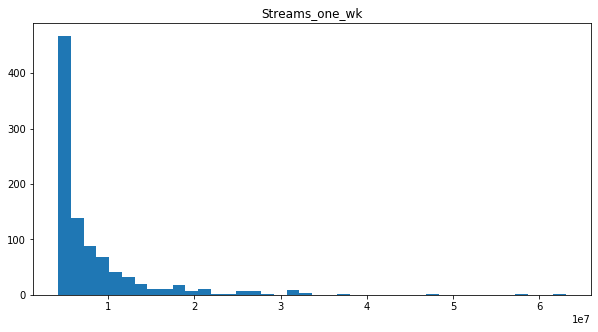

In [6]:
df_songs_features_streams_lyricscores.hist(column = "Streams_one_wk", bins=40, 
                                            figsize=(10, 5), grid=False, );

### Lyric Sentiment Positive Score

When we look at the Positive Sentiment scores for all of the tracks its interesting that most tend toward 0 or "less positive". This was actually a bit of a surprise, but understandable as the sentiment analizer can often mistake music slang. In future productions we will further train our sentiment analizer with modern urban and pop slang which is heavly reflected in music.

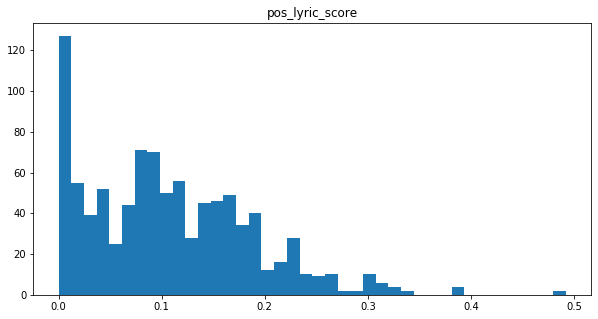

In [7]:
df_songs_features_streams_lyricscores.hist(column = "pos_lyric_score", bins=40, 
                                            figsize=(10, 5), grid=False, );

### Lyric Sentiment Negative Score

When we look at the Negative Sentiment scores we see these are also hudled toward 0 or "less negative" however not with the same intensity as the positive. Its important to note that our sentiment analizer runs completely seperate analysis for negative and positive sentiment. How it scores something as "negative" is not simply the reverse of positive, but is trained againts spearate words and phrases deemed as holding negative sentiment.

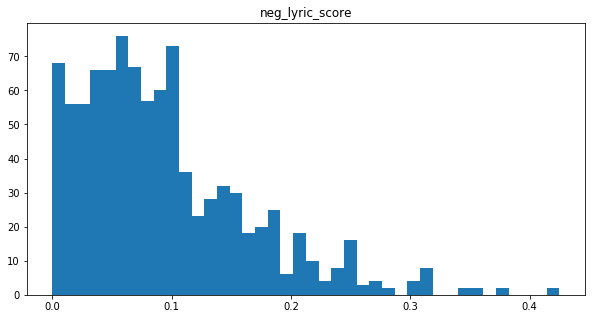

In [10]:
df_songs_features_streams_lyricscores.hist(column = "neg_lyric_score", bins=40, 
                                            figsize=(10, 5), grid=False, );

### Lyric Sentiment Neutral Score

Looking at the Neutral score we see a completely more detailed picture. More are tending toward nuetral, whcih is reflected with the combination of our negative and positive scores. This would align with what I would expect music to be as its across the board of emotions and topics.

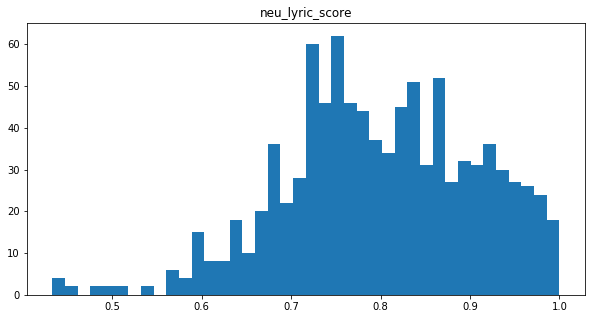

In [11]:
df_songs_features_streams_lyricscores.hist(column = "neu_lyric_score", bins=40, 
                                            figsize=(10, 5), grid=False, );

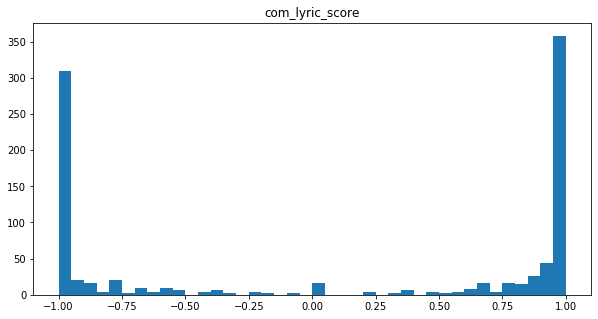

In [12]:
df_songs_features_streams_lyricscores.hist(column = "com_lyric_score", bins=40, 
                                            figsize=(10, 5), grid=False, );

### Followers to Streams Relationship

Here we examine the relationship between the number of Followers an artist has and the amount how first week streams received. I expected a linear relationship where an artist with more followers would receive higher streams, however this has proven less linear. There is not much of a direct correlation, and there are several artist with many followers who received low stream counts and vice versa.

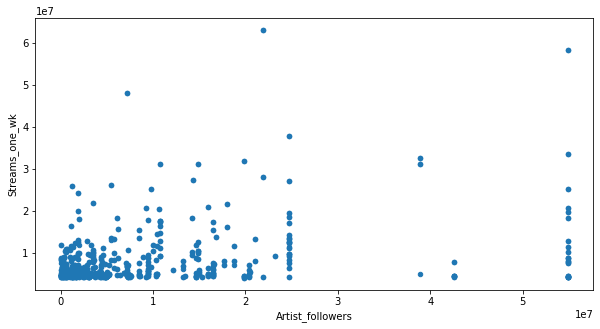

In [83]:
df_songs_features_streams_lyricscores.plot(kind='scatter', 
                                            x = 'Artist_followers', y = 'Streams_one_wk',
                                            figsize = (10,5), legend=True, );

#test_df.plot(kind="scatter", x="X", y="Y", c="C");


### Popularity to Streams Relationship

Here we examine the relationship between the artist's popularity score calculated by Spotify has and the amount how first week streams received. This shows a lot more of the expected direct relationship. Its pretty clear that on average artist with more popularity recieve greater streams. I imagine there is some cross culinarity due to how Spotify calculates the artist's popularity score which likely takes into account recent streams, but this is a blax box model so I cant be sure.

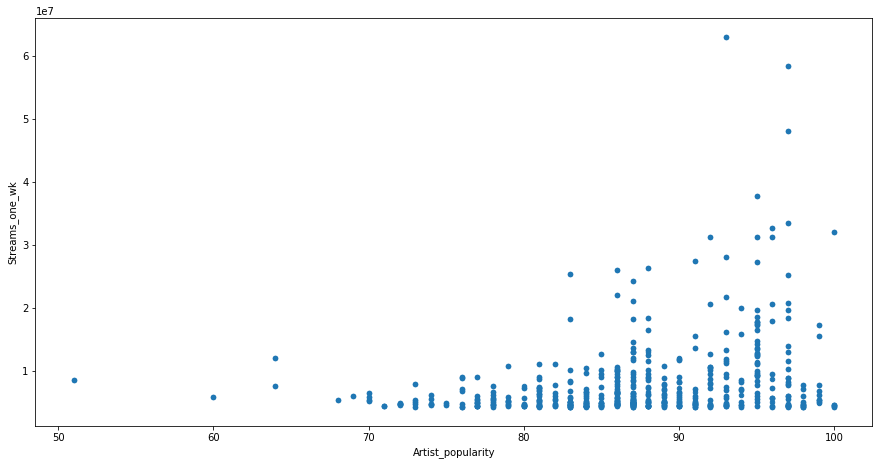

In [80]:
df_songs_features_streams_lyricscores.plot(kind='scatter', 
                                            x = 'Artist_popularity', y = 'Streams_one_wk',
                                            figsize = (15,7.5), legend=True, );

In [297]:
# CONVERT THE GENRES LIST TO STRING FOR SIMPLE HISTOGRAM

for each in df_songs_features_streams_lyricscores['Artist_genres']:
    print(each)
    each = str(each)

    

#df_songs_features_streams_lyricscores['Artist_genres'] = str(df_songs_features_streams_lyricscores['Artist_genres'])

0      [dance pop, pop, post-teen pop]
1                                [pop]
2                 [pop, post-teen pop]
3               [alternative r&b, pop]
4       [alternative r&b, melodic rap]
                    ...               
943      [french hip hop, pop urbaine]
944      [french hip hop, pop urbaine]
945      [french hip hop, pop urbaine]
946             [alternative r&b, pop]
947             [alternative r&b, pop]
Name: Artist_genres, Length: 948, dtype: object
0      [dance pop, pop, post-teen pop]
1                                [pop]
2                 [pop, post-teen pop]
3               [alternative r&b, pop]
4       [alternative r&b, melodic rap]
                    ...               
943      [french hip hop, pop urbaine]
944      [french hip hop, pop urbaine]
945      [french hip hop, pop urbaine]
946             [alternative r&b, pop]
947             [alternative r&b, pop]
Name: Artist_genres, Length: 948, dtype: object
0      [dance pop, pop, post-teen pop]
1      

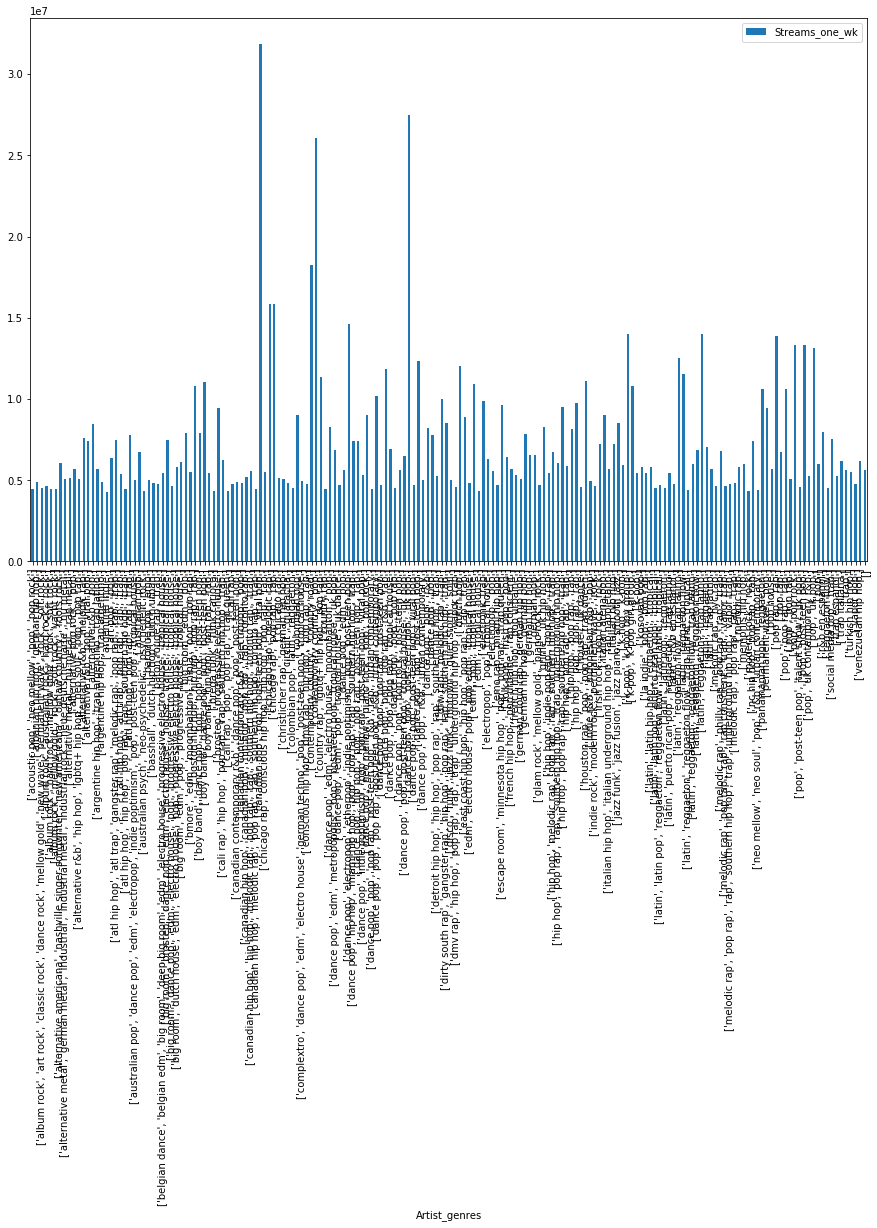

In [28]:
df_streams_by_genre = df_songs_features_streams_lyricscores.groupby('Artist_genres', as_index=False)['Streams_one_wk'].mean()
df_streams_by_genre.plot(x='Artist_genres', y='Streams_one_wk', kind='bar', figsize=(15,10), legend=True);


Here Looking throguh all of the data I can see that my data  looks well distributed, balanced, accurate and authentic. With everything in place, its time to do some modeling!

## Construct our First Model

Now we have a single dataframe with all information from several steps including:

- Song Information
<br> <br>
- Artist Information
<br><br>
- Song Audio Analysis
<br><br>
- Song Lyrics
<br><br>
- Song Lyric Sentiment Scores

This is the key data elements that we need to continue further with creating our first model. Since we are predicting continuous number with several factors, I will use a linear regression approach with feature engineering where helpful. We use all of our numericla columns as features for the model. The only category column which may be helpful to feed the model may be "genres", however for this version we will leave genres out as it will likely have very little impact.

In [31]:
# Setup X, y for the model

X = df_songs_features_streams_lyricscores[['danceability', 'energy', 'key', 'loudness', 'mode', 
                                           'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                                          'valence', 'tempo', 'duration_ms', 'neg_lyric_score', 'neu_lyric_score',
                                          'pos_lyric_score', 'com_lyric_score', 'neg_twitter_artist_score',
                                          'neu_twitter_artist_score', 'pos_twitter_artist_score', 'com_twitter_artist_score', 
                                            'Artist_followers' , 'Artist_popularity'
]]

y = df_songs_features_streams_lyricscores['Streams_one_wk']

In [32]:
lr = LinearRegression()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [70]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
preds = lr.predict(X_test)

In [72]:
lr.score(X_test, y_test)

0.21953185526430216

In [76]:
y_hat = y_test - preds
y_hat

720   -3.395007e+04
671   -2.273226e+06
167    1.520971e+07
851   -4.915693e+06
562    1.838589e+07
           ...     
944   -6.770253e+05
676   -2.226534e+06
181   -2.326054e+06
582   -1.359925e+06
40    -1.557946e+06
Name: Streams_one_wk, Length: 237, dtype: float64

In [85]:
#print(list(zip(model_1.coef_, model_1_features)))

# for each in lr.coef_:
# print(list(zip(each, X_test)))
    
coeff_list  = list(zip(lr.coef_, X_test))
df_coeff_list = pd.DataFrame(coeff_list)
df_coeff_list.to_csv('./data/df_coeff_list.csv')
df_coeff_list.sort_values(by=0, ascending=False)

0                         1
14  2.247465e+08           pos_lyric_score
13  2.210594e+08           neu_lyric_score
12  2.139679e+08           neg_lyric_score
9   1.248370e+06                   valence
8   9.244981e+05                  liveness
15  5.567955e+05           com_lyric_score
21  1.592458e+05         Artist_popularity
3   5.834846e+04                  loudness
2   3.964361e+04                       key
20  7.297673e-02          Artist_followers
19  0.000000e+00  com_twitter_artist_score
18  0.000000e+00  pos_twitter_artist_score
17  0.000000e+00  neu_twitter_artist_score
16 -2.384186e-07  neg_twitter_artist_score
11 -1.165475e+01               duration_ms
10 -8.422243e+03                     tempo
1  -4.692857e+05                    energy
4  -8.573822e+05                      mode
5  -1.055383e+06               speechiness
7  -2.849657e+06          instrumentalness
0  -3.877599e+06              danceability
6  -3.992321e+06              acousticness

# CONCLUSIONS

We have gathered a lot of key data, and constructed a great dataset. Using Natural Language Processing on the lyrics helps us to understand how the model views the lyrics and their impact to stream count. Our model scores an average of R2 score 26% which is a good start. With this model we can explain 26% above the mean for stream count. 

I will continue to iterate through the model to strengthen prediction results. This exercise has sprung many ideas of how I can strengthen this model which I will certainly implement. Some include 


  - Twitter - Acquire premium license to complete auto searching song list
      <br><br>
  - Twitter - Would use https://hashtagify.me/api_pricing  to analysis on hashtags related to ARtist name
      <br><br>
  - Automate the finding twitter user names via twitter user search api vs 'artist_name'
      <br><br>
  - Lyrics NLP - Gram Search - For natural language processing to understand phrases.
      <br><br>
  - Lyrics -NLP train model with UrbanDictionary.com and re-score.
      <br><br>
  - Lyrics - NLP against relevant news headlines to understand if lyrics relevance to current news topics impact stream virality
      <br><br>
  - Gradient Decent Searching
      <br><br>
  - More Feature Engineering



## Appendix 

### Appendix - Get Twitter Activity

I have built the appliction to source twitter activity for each artist in our songs dataframe. The process goes to collect the 500 most recent unique (no-retweets) tweets about the artist. The code takes each of these 500 tweets and generates an individual sentiment analysis with negative, nuetral, positive, and compound scores. 

The 500 Sentitment scores for each artist are then averaged to produce a single "peoples_sentiment" score per artist. That peoples_sentiment score is then merged back into our dataframe to serve as a feature to the model. Given that the lyrics sentiment score is impactful to the mode., the peoples sentiment score is likely to be a strong signal. 

For the purpose of this prototype, we have paused the sourcing of the artists' people_sentiment score from twitter as it produces too many API calls for my free twitter API license and subsequently breaks the code. Since we are sourcing 500 tweets for each of our 1,000+ artist, this request amount is over the free limit. We could reduce the amount of tweents per person, however doing lower numbers runs the risk of heavy bias. A large number of tweets from several people will ensure a proper average sentiment.

If one purchases a parntner licesne with twitter, we can simply un-comment this section and re-run.

In [85]:
# import os
# import tweepy as tw

In [86]:
# consumer_key= 'xGuD9oFEatR7COB2LBLjak2a8'
# consumer_secret= 'H9jBKhYOLhnBlaqICdCWffH88Ip6loxgPTtRXc2kML5a5tIV4f'
# access_token= '452732849-EMcsfhQKecCmYISbuYq6AdfONY3Yc7tT2PuGT2Do'
# access_token_secret= 'T57s1QGCdX0tkRbzPZmcb57Cvv852YyDVNScJp7g2LrUm'

In [87]:
# df_songs_features_streams_lyricscores = pd.read_csv('./data/df_songs_features_streams_lyricscores.csv')

In [89]:
# #Set Twitter Authorizations ()
# # https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/get-and-use-twitter-data-in-python/
# auth = tw.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)
# api = tw.API(auth, wait_on_rate_limit=True)

In [123]:
# # Define the search term and the date_since date as variables
# # Search Word would = each.Artist Name in my loop
# search_words = "wiz khalifa"
# date_since = "2019-11-26"

In [ ]:
# # Collect tweets
# # WORKING JUST TAKES A VERY LONG TIME!!!!!
# # WORKING JUST TAKES A VERY LONG TIME!!!!!
# # WOULD BE 2650 TWEETS TOTAL (10 PER 265 SONGS)

# artist_tweets_list = []

# for each in df_songs_features_streams_lyricscores['Artist_Name']:
#     search_words = each
#     date_since = "2019-11-26"

#     tweets = tw.Cursor(api.search,
#               q=search_words,
#               lang="en",
#               since=date_since).items(10)
        
#     print(each)
#     for tweet in tweets:
#         artist_tweets_list.append(tweet.text)

In [226]:
# len(artist_tweets_list)

In [ ]:
# tweets = tw.Cursor(api.search,
#               q=search_words,
#               lang="en",
#               since=date_since).items(10)

In [ ]:
# # The above approach uses a standard for loop. However, this is an excellent place to use a Python list comprehension. 
# # A list comprehension provides an efficient way to collect object elements contained within an iterator as a list.

# tweets = tw.Cursor(api.search,
#                        q=search_words,
#                        lang="en",
#                        since=date_since).items(100)



# # Collect a list of tweets
# [tweet.text for tweet in tweets]

In [ ]:
# # Need a filter to count the Re-Tweets to know the total action.
# new_search = search_words + " -filter:retweets"
# new_search


In [ ]:
# # Gonna Use this one which takes the 1000 recent tweets about the artists
# # Then we will score each and average the scores as input

# all_artist_tweets = []
# for index, row in df_songs_features_streams_lyricscores.iterrows():
#     search_words = row['Artist_Name']
#     new_search = search_words + " -filter:retweets"
    
#     tweets = tw.Cursor(api.search,
#                        q=new_search,
#                        lang="en",
#                        since=date_since).items(100)

#     for tweet in tweets:
#         tweet_dict = {
#             'tweet_text': tweet.text,
#             'Artist_Name' : search_words,
#             'neg_twitter_artist_score': 0,
#             'neu_twitter_artist_score': 0,
#             'pos_twitter_artist_score': 0,
#             'com_twitter_artist_score': 0
#         }
#         artist_tweets = []
#         artist_tweets.append(tweet_dict)
#         df_artist_tweets = pd.DataFrame(artist_tweets)
        
#         scores = sa(df_artist_tweets['tweet_text'])
#         df_scores = pd.DataFrame(scores)
        
# #         df_artist_tweets['neg_twitter_artist_score'] = df_socres['neg']
# #         df_artist_tweets['neu_twitter_artist_score'] = df_socres['neu']
# #         df_artist_tweets['pos_twitter_artist_score'] = df_socres['pos']
# #         df_artist_tweets['com_twitter_artist_score'] = df_socres['com']
        
#         row['neg_twitter_artist_score'] = df_socres['neg_twitter_artist_score'].mean()
#         row['neu_twitter_artist_score'] = df_scores['neu_twitter_artist_score'].mean()
#         row['pos_twitter_artist_score'] = df_scores['pos_twitter_artist_score'].mean()
#         row['com_twitter_artist_score'] = df_scores['com_twitter_artist_score'].mean()
        
        


In [ ]:
# # Gonna Use this one which takes the 1000 recent tweets about the artists
# # Then we will score each and average the scores as input
# tweets = tw.Cursor(api.search,
#                        q=new_search,
#                        lang="en",
#                        since=date_since).items(100)

# tweet_list = [tweet.text for tweet in tweets]
# tweet_list

In [ ]:
# # Find User names and who is tweeting about the search term
# # Not filtering retweets.
# tweets = tw.Cursor(api.search, 
#                            q=search_words,
#                            lang="en",
#                            since=date_since).items(100)

# users_locs = [[tweet.user.screen_name, tweet.user.location] for tweet in tweets]
# users_locs[:3]

In [ ]:
# sia = SentimentIntensityAnalyzer()


In [ ]:

# #Get all from Artist Tweets alien
# tweet_scores=[]
# for tweet in tweet_list:
#     scores = sia.polarity_scores(tweet)
#     tweet_scores.append(scores)

In [ ]:
# #Take the tweet scores list of dictionaries to a DF to average them
# df_tweet_scores = pd.DataFrame(tweet_scores)
# df_tweet_scores.head()

In [ ]:
# #Store the averages 
# avg_neg = df_tweet_scores['neg'].mean() 
# avg_neu = df_tweet_scores['neu'].mean() 
# avg_pos = df_tweet_scores['pos'].mean() 
# avg_com = df_tweet_scores['compound'].mean() 

In [ ]:
# avg_neg, avg_neu, avg_pos, avg_com